In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


# color_pal = sns.color_palette("husl", 24)
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("PJME_hourly.csv")
df.index = pd.to_datetime(df["Datetime"])
df.head()

,Datetime,PJME_MW
Datetime,,
2002-12-31 01:00:00,2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,2002-12-31 05:00:00,24860.0


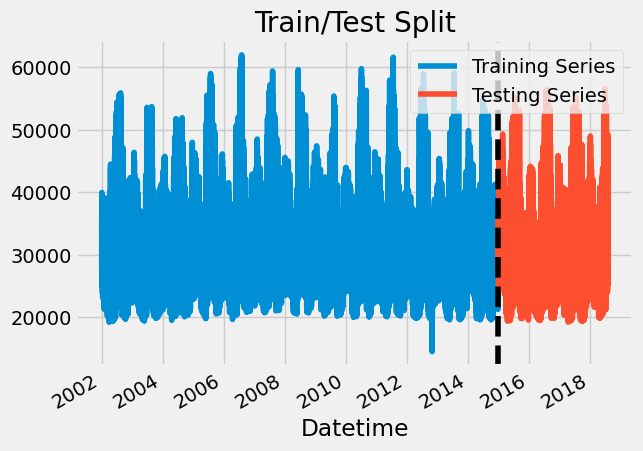

In [3]:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index > "01-01-2015"]

fig, ax = plt.subplots()
train.plot(ax=ax, label="Training Series", title="Train/Test Split")
test.plot(ax=ax, label="Testing Series")
ax.axvline("01-01-2015", color="black", ls="--")

ax.legend(["Training Series", "Testing Series"])

<Axes: title={'center': 'One Weak'}, xlabel='Datetime'>

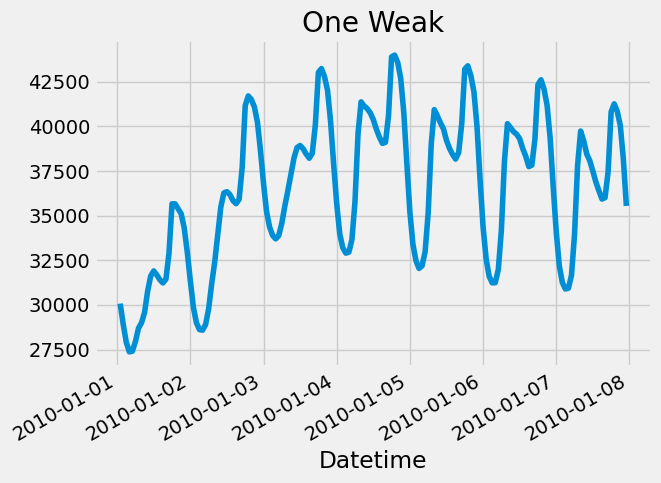

In [4]:
df.loc[(df.index > "01-01-2010") & (df.index < "01-08-2010")].plot(legend=False, title="One Weak")

In [5]:
def create_features(df):    
    df = df.copy()
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["day_of_year"] = df.index.dayofyear
    return df

In [6]:
df = create_features(df)
df.head()

,Datetime,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year
Datetime,,,,,,,,
2002-12-31 01:00:00,2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


Text(0, 0.5, 'MW')

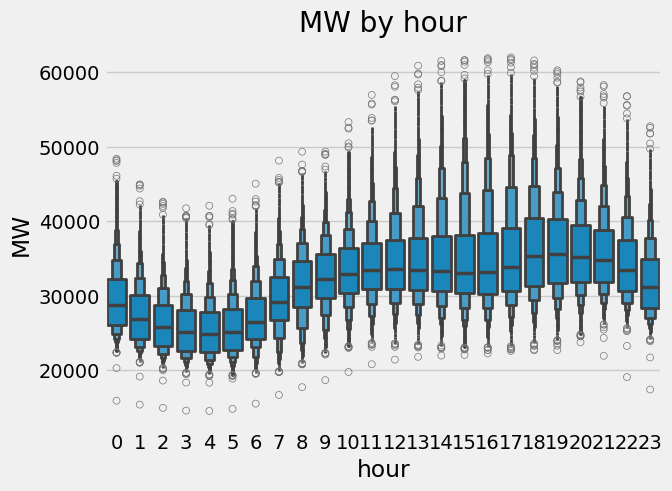

In [7]:
ax = sns.boxenplot(data=df, x="hour", y="PJME_MW", legend=False)
ax.set_title("MW by hour")
ax.set_ylabel("MW")

Text(0, 0.5, 'MW')

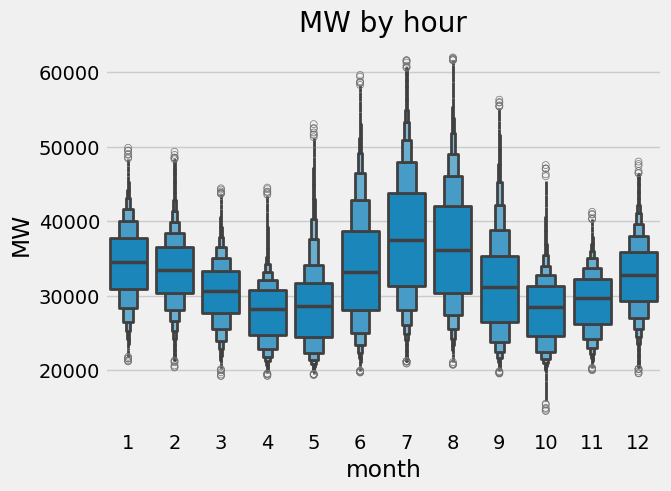

In [8]:
ax = sns.boxenplot(data=df, x="month", y="PJME_MW", legend=False)
ax.set_title("MW by hour")
ax.set_ylabel("MW")

In [9]:
train = create_features(train)
test = create_features(test)

features = df.columns[(df.columns != "PJME_MW") & (df.columns != "Datetime")]
target = df.columns[1]

x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [10]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.12997


/home/talocha/PyTorch/Data Science/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:53:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.21982
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.54842
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.49856
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.64442
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.42645
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.08421
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.49489
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.41767
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.05411
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.98037


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

<Axes: title={'center': 'Feature Importance'}>

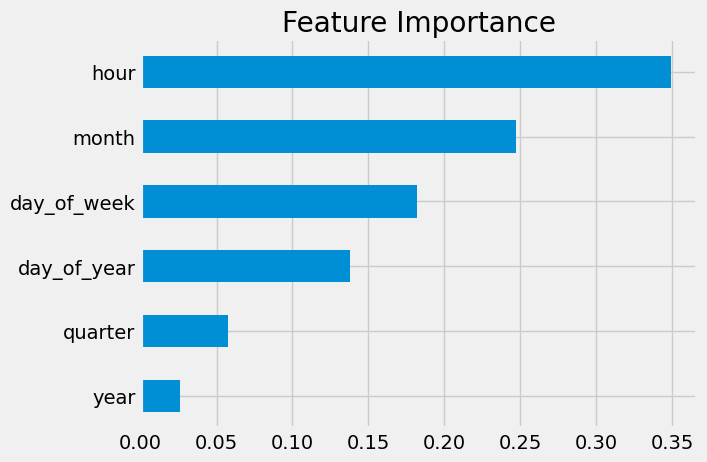

In [11]:
reg_final = pd.DataFrame(data=reg.feature_importances_,
                         index=reg.feature_names_in_,
                         columns=["importance"])

reg_final.sort_values("importance").plot(kind="barh", title="Feature Importance", legend=False)

In [12]:
test["predictions"] = reg.predict(x_test)
df = df.merge(test["predictions"], how="left", left_index=True, right_index=True)

Text(0.5, 1.0, 'Raw Data and Prediction')

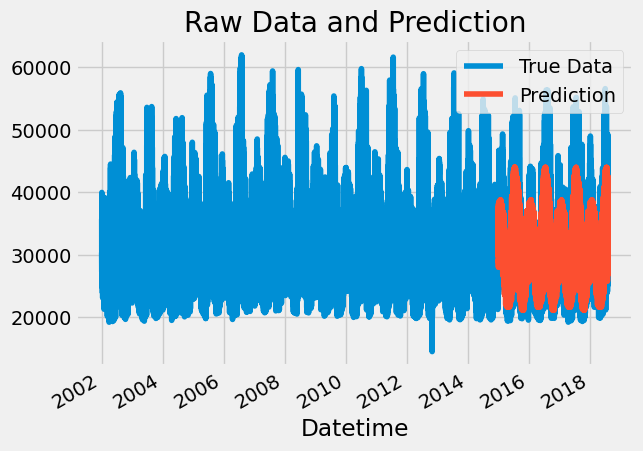

In [13]:
ax = df["PJME_MW"].plot()
df["predictions"].plot()
plt.legend(["True Data", "Prediction"])
ax.set_title("Raw Data and Prediction")

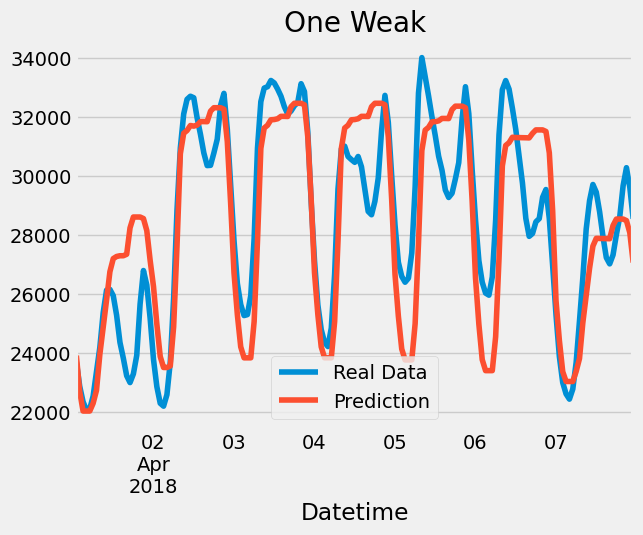

In [14]:
df.loc[(df.index > "04-01-2018") & (df.index < "04-08-2018")]["PJME_MW"].plot(legend=False, title="One Weak")
df.loc[(df.index > "04-01-2018") & (df.index < "04-08-2018")]["predictions"].plot()
plt.legend(["Real Data", "Prediction"])

In [15]:
score = np.sqrt(mean_squared_error(test["PJME_MW"], test["predictions"]))
print(f"MSE Score on Test set:{score:0.2f}")

MSE Score on Test set:3726.83


In [16]:
test["error"] = np.abs(test[target] - test["predictions"])
test["date"] = test.index.date
test.groupby(["date"])["error"].mean().sort_values(ascending=False).head()

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
Name: error, dtype: float64

# LETS IMPROVE THIS

#### Lets remove some outliers

In [17]:
df = pd.read_csv("PJME_hourly.csv")
df.index = pd.to_datetime(df["Datetime"])
df.head()

,Datetime,PJME_MW
Datetime,,
2002-12-31 01:00:00,2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,2002-12-31 05:00:00,24860.0


<Axes: title={'center': 'PJME Energy Used in MW'}, xlabel='Datetime'>

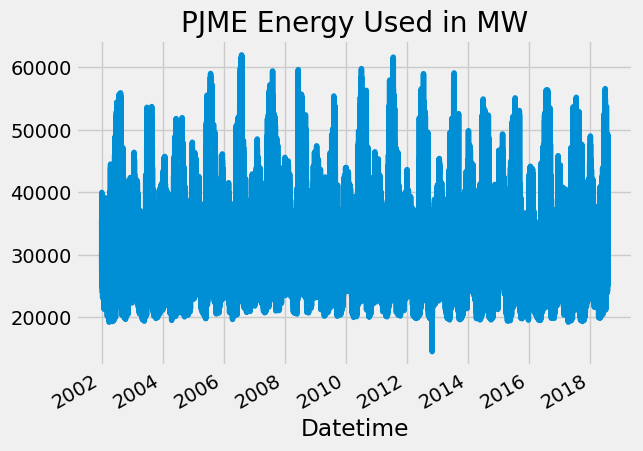

In [18]:
df.plot(legend=False, title="PJME Energy Used in MW")

We can see that around 2014 we have some values that seems to not be correct

<Axes: ylabel='Frequency'>

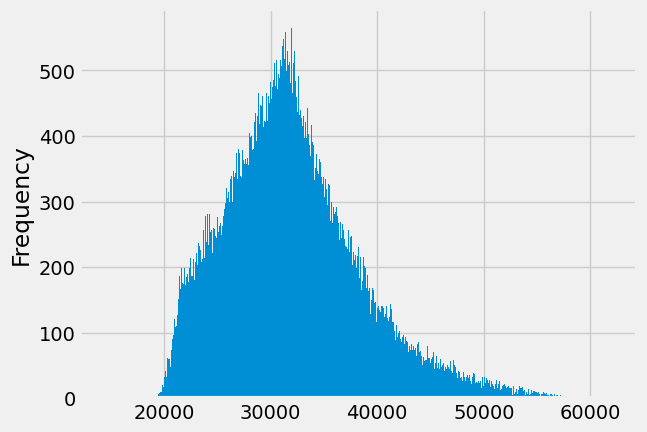

In [19]:
df.plot(kind="hist", bins=1000, legend=False)

<Axes: xlabel='Datetime'>

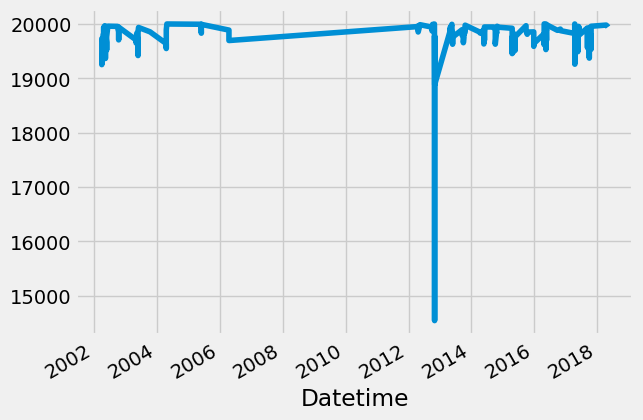

In [20]:
df.query("PJME_MW < 20_000").plot(legend=False)

<Axes: xlabel='Datetime'>

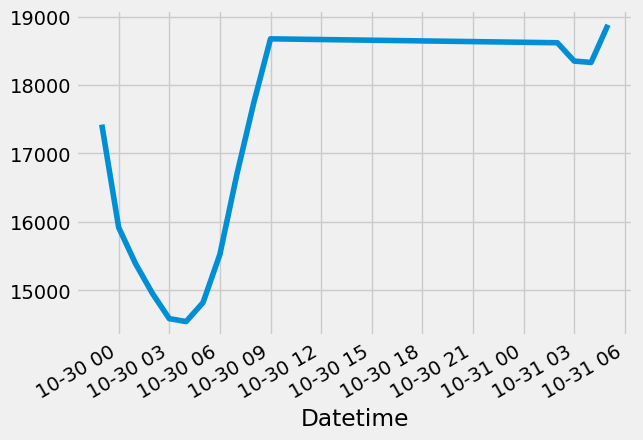

In [21]:
df.query("PJME_MW < 19_000").plot(legend=False)

<Axes: title={'center': 'PJME Energy Used in MW'}, xlabel='Datetime'>

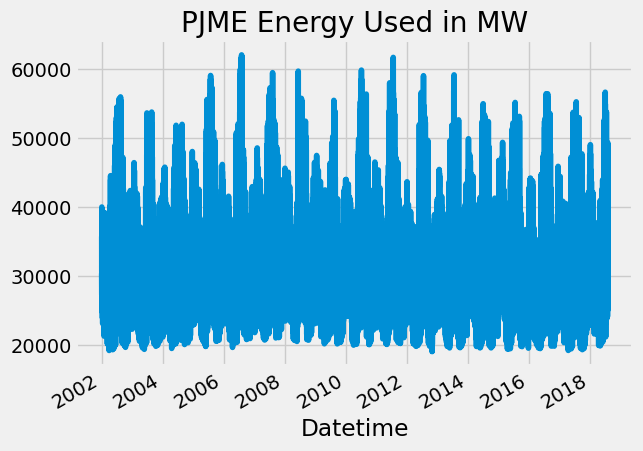

In [22]:
df = df.query("PJME_MW>19_000").copy()
df.plot(title="PJME Energy Used in MW", legend=False)

#### Cross Validation

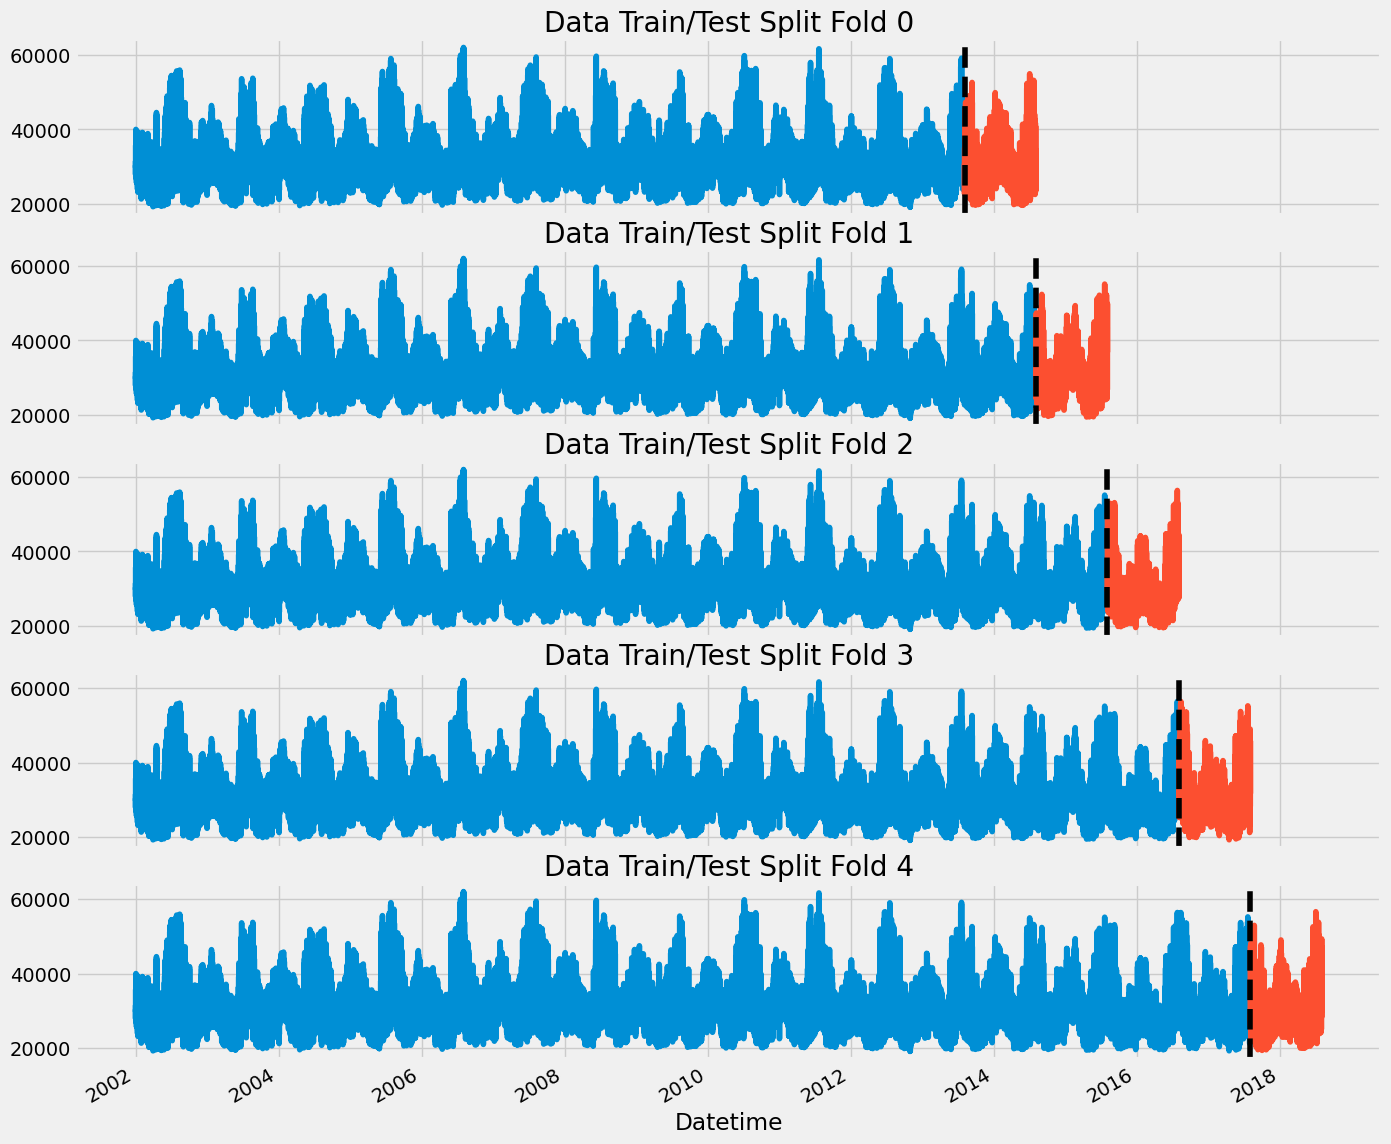

In [23]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5,1, figsize=(15,15), sharex=True)

fold = 0

for train_index, test_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    
    train["PJME_MW"].plot(ax=axs[fold], 
                          legend=False,
                          title=f"Data Train/Test Split Fold {fold}")
    test["PJME_MW"].plot(ax=axs[fold], legend=False)
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1
plt.show()

In [24]:
df = create_features(df)

def create_lag(df):
    df = df.copy()
    target_map = df["PJME_MW"].to_dict()

    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("768 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

df = create_lag(df)

In [25]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
features = df.columns[(df.columns != "PJME_MW") & (df.columns != "Datetime")]
target = df.columns[1]


for train_index, test_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    
    train = create_features(train)
    test = create_features(test)
    
    x_train = train[features]
    y_train = train[target]
    
    x_test = test[features]
    y_test = test[target]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster="gbtree",
                           n_estimators=1000,
                           early_stopping_rounds = 50,
                           objective="reg:linear",
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(x_train, y_train, 
            eval_set=[(x_train, y_train), (x_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(x_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    fold += 1
    

[0]	validation_0-rmse:32732.50316	validation_1-rmse:31953.87518


/home/talocha/PyTorch/Data Science/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:53:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12543.28204	validation_1-rmse:11815.64598
[200]	validation_0-rmse:5744.59150	validation_1-rmse:5232.37076
[300]	validation_0-rmse:3883.72607	validation_1-rmse:3826.49430
[400]	validation_0-rmse:3452.04794	validation_1-rmse:3712.36761
[434]	validation_0-rmse:3395.88438	validation_1-rmse:3718.24199
[0]	validation_0-rmse:32672.17511	validation_1-rmse:32140.32756


/home/talocha/PyTorch/Data Science/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:54:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12523.70753	validation_1-rmse:12253.50238
[200]	validation_0-rmse:5760.46771	validation_1-rmse:5703.25335
[300]	validation_0-rmse:3913.67299	validation_1-rmse:3977.57814
[400]	validation_0-rmse:3492.02631	validation_1-rmse:3650.83721
[500]	validation_0-rmse:3366.90394	validation_1-rmse:3586.52284
[600]	validation_0-rmse:3306.31648	validation_1-rmse:3556.27031
[700]	validation_0-rmse:3259.94889	validation_1-rmse:3546.30866
[800]	validation_0-rmse:3224.32221	validation_1-rmse:3538.86977
[900]	validation_0-rmse:3196.02692	validation_1-rmse:3528.24112
[999]	validation_0-rmse:3169.40010	validation_1-rmse:3521.40870
[0]	validation_0-rmse:32631.22342	validation_1-rmse:31073.40617


/home/talocha/PyTorch/Data Science/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:54:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12510.13744	validation_1-rmse:11142.32227
[200]	validation_0-rmse:5769.01742	validation_1-rmse:4766.37471
[300]	validation_0-rmse:3930.32703	validation_1-rmse:3482.44305
[400]	validation_0-rmse:3510.73001	validation_1-rmse:3439.45809
[402]	validation_0-rmse:3506.88001	validation_1-rmse:3439.64358
[0]	validation_0-rmse:32528.44574	validation_1-rmse:31475.30538


/home/talocha/PyTorch/Data Science/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:54:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12471.75515	validation_1-rmse:12075.49626
[200]	validation_0-rmse:5757.88539	validation_1-rmse:5792.49747
[300]	validation_0-rmse:3922.29347	validation_1-rmse:4316.29175
[400]	validation_0-rmse:3510.24658	validation_1-rmse:4067.00935
[500]	validation_0-rmse:3391.66519	validation_1-rmse:4017.79465
[600]	validation_0-rmse:3336.04753	validation_1-rmse:4002.36546
[652]	validation_0-rmse:3313.40164	validation_1-rmse:4005.69572
[0]	validation_0-rmse:32462.05623	validation_1-rmse:31462.37269


/home/talocha/PyTorch/Data Science/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:54:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12455.06654	validation_1-rmse:11930.13529
[200]	validation_0-rmse:5768.17706	validation_1-rmse:5581.36607
[300]	validation_0-rmse:3952.47348	validation_1-rmse:4159.09504
[400]	validation_0-rmse:3547.70802	validation_1-rmse:4005.09371
[493]	validation_0-rmse:3439.67699	validation_1-rmse:4011.00705


In [26]:
print(f"Score across folds {np.mean(scores):0.4f}")
print(f"Fold Scores: {scores}")

Score across folds 3728.7391
Fold Scores: [3710.4726160059254, 3521.4087009448504, 3413.952636594363, 4001.329602603029, 3996.532096616591]


In [27]:
df = create_features(df)

x_all = df[features]
y_all = df[target]

reg = xgb.XGBRegressor(base_score=0.5, 
                       booster="gbtree",
                       n_estimators=500,
                       early_stopping_rounds = 50,
                       objective="reg:linear",
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(x_all, y_all, 
        eval_set=[(x_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.89057


/home/talocha/PyTorch/Data Science/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:54:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12435.82782
[200]	validation_0-rmse:5769.45664
[300]	validation_0-rmse:3977.14268
[400]	validation_0-rmse:3573.35467
[499]	validation_0-rmse:3462.81041


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [28]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [34]:
future_time = pd.date_range("2018-08-03", "2019-08-01", freq="1h")
future_df = pd.DataFrame(index=future_time)
future_df["isFuture"] = True
df["isFuture"] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = create_lag(df_and_future)
df_and_future.drop("Datetime", axis=1, inplace=True)
df_and_future.head()

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN,False


<Axes: >

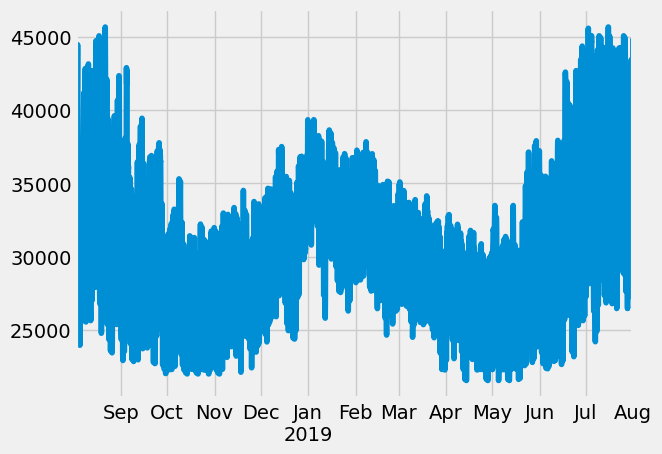

In [38]:
feature_w_features = df_and_future.query("isFuture").copy()

feature_w_features["pred"] = reg.predict(feature_w_features[features])

feature_w_features["pred"].plot()

In [36]:
feature_w_features.head()

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,33539.0,29646.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,30781.0,27130.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,29015.0,25282.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,27884.0,24050.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,27223.0,23186.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,46912.0,43374.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,45985.0,42248.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,44094.0,41330.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,40666.0,38838.0,34641.0,True
